In [1]:
## Library imports
import random
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

In [16]:
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import des données

Usage de la librairie glob, qui utilise la syntaxe shell unix pour lister un très grand nombre de fichier en même temps. 

In [2]:
import glob
import pandas as pd
import os

working_dir = os.listdir('./data')

if 'data_test.csv' not in working_dir:
    
    file_paths_neg = glob.glob("imdb_data/aclImdb/test/neg/*.txt")
    data_test_neg = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_neg], ignore_index=True)
    
    file_paths_pos = glob.glob("imdb_data/aclImdb/test/pos/*.txt")
    data_test_pos = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_pos], ignore_index=True)
    
    data_test_neg["label"] = str(0)
    
    data_test_pos["label"] = str(1)
    
    data_test = pd.concat((data_test_neg, data_test_pos)).reset_index(drop=True)
else:
    data_test = pd.read_csv("./data/data_test.csv")
    data_test = data_test.drop(columns=data_test.columns[0])
    
    
if 'data_train.csv' not in working_dir:
    
    file_paths_train_neg = glob.glob("imdb_data/aclImdb/train/neg/*.txt")
    data_train_neg = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_train_neg], ignore_index=True)
    
    file_paths_train_pos = glob.glob("imdb_data/aclImdb/train/pos/*.txt")
    data_train_pos = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_train_pos], ignore_index=True)
    
    data_train_neg["label"] = str(0)
    
    data_train_pos["label"] = str(1)
    
    data_train = pd.concat((data_train_neg, data_train_pos)).reset_index(drop=True)
else:
    data_train = pd.read_csv('./data/data_train.csv')
    data_train = data_train.drop(columns=data_train.columns[0])

In [3]:
print(data_train)

                                                    text  label
0      I rented I AM CURIOUS-YELLOW from my video sto...      0
1      "I Am Curious: Yellow" is a risible and preten...      0
2      If only to avoid making this type of film in t...      0
3      This film was probably inspired by Godard's Ma...      0
4      Oh, brother...after hearing about this ridicul...      0
...                                                  ...    ...
24995  A hit at the time but now better categorised a...      1
24996  I love this movie like no other. Another time ...      1
24997  This film and it's sequel Barry Mckenzie holds...      1
24998  'The Adventures Of Barry McKenzie' started lif...      1
24999  The story centers around Barry McKenzie who mu...      1

[25000 rows x 2 columns]


## TENSORFLOW

In [4]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv 

train_data = pd.read_csv('./data/data_train.csv').drop("Unnamed: 0", axis=1)
test_data = pd.read_csv('./data/data_test.csv').drop("Unnamed: 0", axis=1)

test_data["label"] = pd.to_numeric(test_data["label"])
train_data["label"] = pd.to_numeric(train_data["label"])

2024-12-18 16:57:24.188377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734537444.208248    8452 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734537444.214294    8452 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 16:57:24.234569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
test_data["label"].unique()

array([0, 1])

In [6]:
test_data

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


In [7]:
import matplotlib.pyplot as plt 

def plot_training_analysis(history):    

    metrics = ['accuracy', 'loss']

    plt.figure(figsize=(15,5))
    
    for idx, metric in enumerate(metrics):
        plt.subplot(1,2,idx+1)
        loss = history.history[metric]
        val_loss = history.history['val_' + metric]
    
        epochs = range(len(loss))
    
        plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
        plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
        plt.title('Training and validation ' + metric)
        plt.legend()

In [8]:
# Séparer les textes et les labels
x_train_raw, y_train = train_data['text'], train_data['label']
x_test_raw, y_test = test_data['text'], test_data['label']

# Tokenisation et padding
max_features = 10000  # Limite du vocabulaire
max_len = 500  # Longueur maximale des séquences

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train_raw)

x_train = tokenizer.texts_to_sequences(x_train_raw)
x_train = pad_sequences(x_train, maxlen=max_len)

x_test = tokenizer.texts_to_sequences(x_test_raw)
x_test = pad_sequences(x_test, maxlen=max_len)


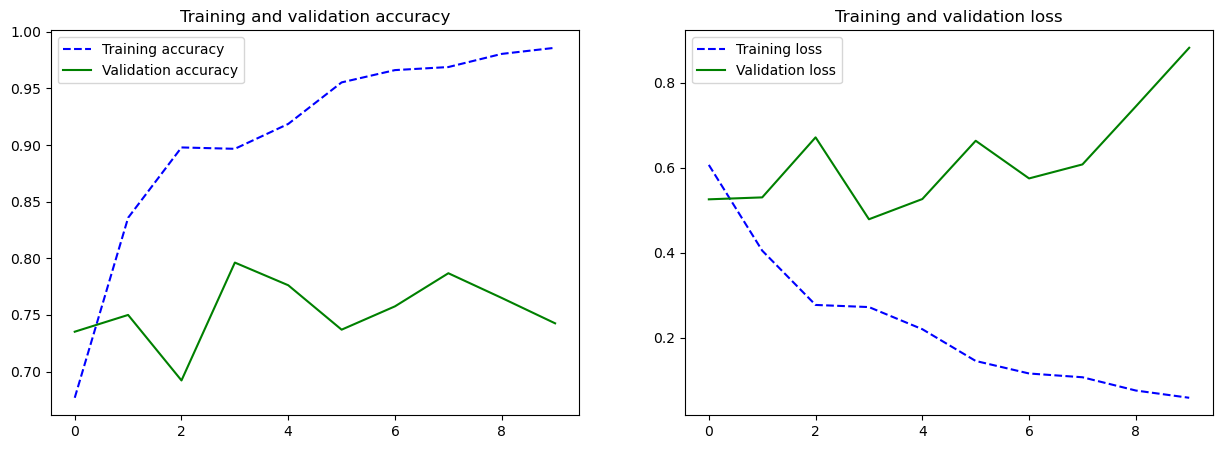

In [12]:
plot_training_analysis(history_rnn)

Choix des hyper-paramètres :

Batch size : 

- Un batch size de 32 semble optimal.

Learning rate :

- L'entraînement du modèle semble "aléatoire". Baisser le learning rate en conséquence. 10-3 -> 10-4

Nombre d'epochs:

- Avec 10 epochs, on est déjà en overfitting. Plus d'epochs parait inutile dans ce cas. 

Remarque :

On est sûrement en face d'un problème d'exploding gradients. L'entraînement est quelque peu erratique, et la précision/loss de validation fait des sauts au cours de l'entraînement. Au final, la précision obtenue est plutôt bonne, mais on aurait aussi bien pu tomber sur une epoch malchanceuse, gâchant toute une phase d'entraînement. Ainsi, on a mis en place un checkpoint, pour revenir au meilleur modèle au cours de l'entraînement.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model_RNN_checkpoint = Sequential([
    Embedding(max_features, 128),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lr = 10**(-4)                

# Compiler le modèle
model_RNN_checkpoint.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy']) 

# Définir le chemin pour sauvegarder le modèle
best_model_path = './models/best_RNN_model.keras'

# Callback pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint(filepath=best_model_path,
                             monitor='val_accuracy',        # Surveille la perte sur validation
                             save_best_only=True,       # Sauvegarde seulement si meilleur
                             mode='max',                # Cherche la valeur minimale de val_loss
                             verbose=1)

train_RNN = True

# Entraîner le modèle avec le callback
if train_RNN:
    history_rnn_checkpoint = model_RNN_checkpoint.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[checkpoint])
else:
    # Charger les meilleurs poids sauvegardés
    model_RNN.load_weights(best_model_path)

# Évaluer le modèle
test_loss, test_accuracy = model_RNN_checkpoint.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5764 - loss: 0.6808
Epoch 1: val_loss improved from inf to 0.93556, saving model to ./models/best_RNN_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.5765 - loss: 0.6808 - val_accuracy: 0.2014 - val_loss: 0.9356
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7706 - loss: 0.5133
Epoch 2: val_loss improved from 0.93556 to 0.65111, saving model to ./models/best_RNN_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.7706 - loss: 0.5133 - val_accuracy: 0.6500 - val_loss: 0.6511
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8663 - loss: 0.3633
Epoch 3: val_loss improved from 0.65111 to 0.54623, saving model to ./models/best_RNN_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.8663 - loss: 0.3632 - val_accuracy: 0.7562 - val_loss: 0.5462
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8784 - loss: 0.3238
Epoch

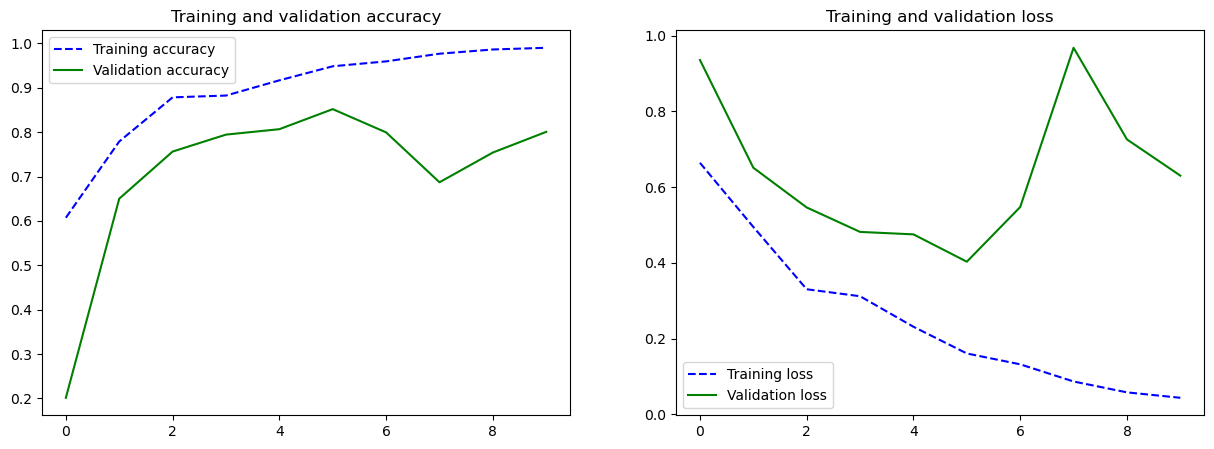

In [21]:
plot_training_analysis(history_rnn_checkpoint)

Le checkpoint nous permet de ne garder que le meilleur modèle. Ici, on évite au modèle de passer par la phase de sur-apprentissage, qui est plus destructive qu'autre chose pour notre modèle.

## MLP 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Créer et ajuster le TfidfVectorizer
tfidf = TfidfVectorizer(max_features=max_features)
x_train_tfidf = tfidf.fit_transform(x_train_raw).toarray()
x_test_tfidf = tfidf.transform(x_test_raw).toarray()

# Définir un modèle MLP ou RNN sur ces vecteurs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model_MLP = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_tfidf.shape[1],)),
    Dropout(0.7),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# Compiler et entraîner
model_MLP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_MLP.fit(x_train_tfidf, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Évaluation
test_loss, test_accuracy = model_MLP.evaluate(x_test_tfidf, y_test)
print(f"Test Accuracy: {test_accuracy}")


/home/richaume/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7138 - loss: 0.5337 - val_accuracy: 0.7622 - val_loss: 0.5483
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9202 - loss: 0.2164 - val_accuracy: 0.7770 - val_loss: 0.5669
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9463 - loss: 0.1571 - val_accuracy: 0.7308 - val_loss: 0.7247
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9576 - loss: 0.1240 - val_accuracy: 0.7604 - val_loss: 0.7386
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9652 - loss: 0.1010 - val_accuracy: 0.7578 - val_loss: 0.7820
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9768 - loss: 0.0738 - val_accuracy: 0.8042 - val_loss: 0.7258
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9769 - loss: 0.0683 - val_accuracy: 0.7048 - val_loss: 1.1990
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9833 - loss: 0.0517 - val_accuracy: 0.

## LSTM

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# Définir le modèle LSTM
model_LSTM = Sequential([
    Embedding(max_features, 128, input_length=max_len),  # Vecteurs d'embedding
    LSTM(128, activation='tanh', return_sequences=False),  # Couche LSTM principale
    Dropout(0.5),  # Réduction du surapprentissage
    Dense(1, activation='sigmoid')  # Couche de sortie
])

lr = 10**(-4) 

# Compiler le modèle
model_LSTM.compile(optimizer='adam',  # optimizer=Adam(learning_rate=lr)
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Définir le chemin pour sauvegarder le modèle
best_LSTM_path = './models/best_LSTM_model.keras'

# Callback pour sauvegarder le meilleur modèle
LSTM_checkpoint = ModelCheckpoint(filepath=best_LSTM_path,
                             monitor='val_accuracy',        # Surveille la perte sur validation
                             save_best_only=True,       # Sauvegarde seulement si meilleur
                             mode='max',                # Cherche la valeur minimale de val_loss
                             verbose=1)

train_LSTM = True

# Entraîner le modèle avec le callback
if train_LSTM:
    history_LSTM_checkpoint = model_LSTM.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[LSTM_checkpoint])
else:
    # Charger les meilleurs poids sauvegardés
    model_LSTM.load_weights(best_model_path)

# Évaluer le modèle
test_loss, test_accuracy = model_LSTM_checkpoint.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 191s 302ms/step - accuracy: 0.7288 - loss: 0.5405 - val_accuracy: 0.6984 - val_loss: 0.6103
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 288ms/step - accuracy: 0.8699 - loss: 0.3246 - val_accuracy: 0.7638 - val_loss: 0.6240
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 287ms/step - accuracy: 0.8971 - loss: 0.2618 - val_accuracy: 0.7180 - val_loss: 0.8090
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.9269 - loss: 0.1934 - val_accuracy: 0.7146 - val_loss: 0.6481
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.9565 - loss: 0.1292 - val_accuracy: 0.8398 - val_loss: 0.4266
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.9605 - loss: 0.1136 - val_accuracy: 0.6770 - val_loss: 1.1473
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 288ms/step - accuracy: 0.9747 - loss: 0.0780 - val_accuracy: 0.7764 - val_loss: 1.0277
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 184s 295ms/step - accuracy: 0.9682 -

In [88]:
model_LSTM.save_weights('./models/LSTM.weights.h5')

## GRU

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Définir le modèle GRU
model_GRU = Sequential([
    Embedding(max_features, 128, input_length=max_len),  # Vecteurs d'embedding
    GRU(128, activation='tanh', return_sequences=False),  # Couche GRU principale
    Dropout(0.5),  # Réduction du surapprentissage
    Dense(1, activation='sigmoid')  # Couche de sortie
])

lr = 1e-4

# Compiler le modèle
model_GRU.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Définir le chemin pour sauvegarder le modèle
best_GRU_path = './models/best_GRU_model.keras'

# Callback pour sauvegarder le meilleur modèle
GRU_checkpoint = ModelCheckpoint(filepath=best_GRU_path,
                             monitor='val_accuracy',        # Surveille la perte sur validation
                             save_best_only=True,       # Sauvegarde seulement si meilleur
                             mode='max',                # Cherche la valeur minimale de val_loss
                             verbose=1)

train_GRU = True

# Entraîner le modèle avec le callback
if train_GRU:
    history_GRU_checkpoint = model_GRU.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[GRU_checkpoint])
else:
    # Charger les meilleurs poids sauvegardés
    model_GRU.load_weights()

# Évaluer le modèle
test_loss, test_accuracy = model_GRU.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.6164 - loss: 0.6645
Epoch 1: val_accuracy improved from -inf to 0.37280, saving model to ./models/best_GRU_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 370s 589ms/step - accuracy: 0.6164 - loss: 0.6645 - val_accuracy: 0.3728 - val_loss: 0.8275
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7810 - loss: 0.4984
Epoch 2: val_accuracy improved from 0.37280 to 0.63440, saving model to ./models/best_GRU_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 368s 590ms/step - accuracy: 0.7810 - loss: 0.4983 - val_accuracy: 0.6344 - val_loss: 0.7500
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.8577 - loss: 0.3437
Epoch 3: val_accuracy improved from 0.63440 to 0.84740, saving model to ./models/best_GRU_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 371s 593ms/step - accuracy: 0.8577 - loss: 0.3436 - val_accuracy: 0.8474 - val_loss: 0.4016
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.90

NameError: name 'model_GRU_checkpoint' is not defined

In [13]:
#test_loss, test_accuracy = model_GRU.evaluate(x_test, y_test)
#print(f"Test Accuracy: {test_accuracy}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 173ms/step - accuracy: 0.8740 - loss: 0.4552
Test Accuracy: 0.8524799942970276


## CNN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

# Paramètres
max_features = 10000  # Taille maximale du vocabulaire
max_len = 500  # Longueur maximale des séquences

# Définir le modèle CNN
model_CNN = Sequential([
    # Première couche convolutionnelle
    Conv1D(128, 5, activation='relu', input_shape=(max_len, 1)),  # 128 filtres, taille de noyau 5
    MaxPooling1D(5),  # Max pooling avec une taille de 5
    
    # Deuxième couche convolutionnelle
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    
    # Appliquer une couche de pooling global pour réduire les dimensions
    GlobalMaxPooling1D(),  # Applique le pooling global
    
    # Couches denses pour la classification
    Dense(64, activation='relu'),
    Dropout(0.5),  # Dropout pour éviter le sur-apprentissage
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])


# Compiler le modèle
model_CNN.compile(optimizer='adam',  # optimizer=Adam(learning_rate=lr)
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Définir le chemin pour sauvegarder le modèle
best_CNN_path = './models/best_CNN_model.keras'

# Callback pour sauvegarder le meilleur modèle
CNN_checkpoint = ModelCheckpoint(filepath=best_CNN_path,
                                 monitor='val_accuracy',  # Surveille la validation accuracy
                                 save_best_only=True,     # Sauvegarde seulement si meilleur
                                 mode='max',              # Cherche la valeur maximale de val_accuracy
                                 verbose=1)

train_CNN = True

# Entraîner le modèle avec le callback
if train_CNN:
    history_CNN_checkpoint = model_CNN.fit(x_train, y_train,
                                           epochs=10,
                                           batch_size=32,
                                           validation_split=0.2,
                                           callbacks=[CNN_checkpoint])
else:
    # Charger les meilleurs poids sauvegardés
    model_CNN.load_weights(best_CNN_path)

# Évaluer le modèle
test_loss, test_accuracy = model_CNN.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


InternalError: cudaSetDevice() on GPU:0 failed. Status: CUDA-capable device(s) is/are busy or unavailable